# **Advanced Data Transformation Techniques**
(Using `sklearn.compose` and Pipelines )

In real-world data science problems, preprocessing steps often need to be applied selectively to different parts of a dataset. Techniques like **`ColumnTransformer`**, **`Pipeline`**, and other advanced preprocessing methods allow us to automate, simplify, and make the process more efficient. This notebook discusses these advanced preprocessing combinations.

## 1. **ColumnTransformer** – Applying Different Preprocessing to Different Columns

The `ColumnTransformer` allows different preprocessing steps to be applied to different subsets of columns in a dataset. For example, you can apply scaling to numerical columns and one-hot encoding to categorical columns. 

### Example:

In [296]:
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
import pandas as pd 

In [297]:
# Load sample data 
df = pd.read_csv("../datasets/Iris.csv")
df.sample()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
109,110,7.2,3.6,6.1,2.5,Iris-virginica


In [298]:
X = df.drop("Id", axis=1) 
y = df["Species"] 
X.shape

(150, 5)

In [299]:
print(X.sample())
print(y.sample())

    SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
19            5.1           3.8            1.5           0.3  Iris-setosa
11    Iris-setosa
Name: Species, dtype: object


In [300]:
# Define the ColumnTransformer 
preprocessor = ColumnTransformer( 
    transformers=[ 
        ('num', StandardScaler(), ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']), # Normalization these Colums
        ('cat', OneHotEncoder(), ['Species']) # Assuming you had categorical columns 
    ] 
)

In [301]:
# Apply transformations 
X_transformed = preprocessor.fit_transform(X) 
print(X_transformed.shape) # Check the transformed shape

(150, 7)


In [302]:
X_transformed

array([[-0.90068117,  1.03205722, -1.3412724 , ...,  1.        ,
         0.        ,  0.        ],
       [-1.14301691, -0.1249576 , -1.3412724 , ...,  1.        ,
         0.        ,  0.        ],
       [-1.38535265,  0.33784833, -1.39813811, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 0.79566902, -0.1249576 ,  0.81962435, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.4321654 ,  0.80065426,  0.93335575, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.06866179, -0.1249576 ,  0.76275864, ...,  0.        ,
         0.        ,  1.        ]])

### Key Points:

- `ColumnTransformer` is very useful when you want to apply different transformations to different columns, such as standard scaling to numeric columns and encoding categorical columns with one-hot encoding.

- It ensures that the transformations are applied correctly without having to manually split your dataset.

##
---

## 2. **Pipeline** – Creating a Sequential Workflow

A `Pipeline` in scikit-learn helps you encapsulate your preprocessing steps along with model training into one unified workflow. This ensures that the preprocessing steps are correctly applied during both training and prediction.

### Example:

In [303]:
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split 
from sklearn.datasets import load_iris

In [304]:
# Load sample data 
data = load_iris()

In [305]:
X = pd.DataFrame(data.data, columns=data.feature_names) 
y = data.target 
X.shape

(150, 4)

In [306]:
# Split data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [307]:
# Create pipeline with preprocessing and model 
pipeline = Pipeline([ 
    ('scaler', StandardScaler()), # Preprocessing step 
    ('classifier', RandomForestClassifier()) # Model step 
]) 


In [308]:
# Fit pipeline to data 
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier())])

In [309]:
# Evaluate model 
score = pipeline.score(X_test, y_test) 
print("Model accuracy:", score)

Model accuracy: 1.0


### Key Points:

- The `Pipeline` allows for streamlined chaining of multiple steps, including preprocessing (like scaling, imputation) and modeling (like classification or regression).

- The `fit` method applies all transformations and then trains the model.

- Pipelines ensure that the preprocessing steps are applied consistently during cross-validation and testing.

##
---

## 3. **FeatureUnion** – Combining Multiple Pipelines

The `FeatureUnion` combines several transformer objects into a single transformer. This allows you to apply different transformations to the same data and then concatenate their results.

### Example:

In [310]:
from sklearn.pipeline import FeatureUnion 
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split 

In [311]:
# Create two pipelines 
scaler_pipeline = Pipeline([('scaler', StandardScaler())]) 
pca_pipeline = Pipeline([('pca', PCA(n_components=2))]) 

In [312]:
# Combine the pipelines into a FeatureUnion 
combined_pipeline = FeatureUnion([ 
    ('scaler', scaler_pipeline), 
    ('pca', pca_pipeline) 
]) 
combined_pipeline

FeatureUnion(transformer_list=[('scaler',
                                Pipeline(steps=[('scaler', StandardScaler())])),
                               ('pca',
                                Pipeline(steps=[('pca',
                                                 PCA(n_components=2))]))])

In [313]:
# Load data 
data = load_iris() 
X = pd.DataFrame(data.data, columns=data.feature_names) 
y = data.target 

In [314]:
# Apply combined transformations 
X_transformed = combined_pipeline.fit_transform(X) 

In [315]:
print("Transformed data shape:", X_transformed.shape)

Transformed data shape: (150, 6)


### Key Points:

- `FeatureUnion` allows for multiple transformations to be applied in parallel, and their results are concatenated. This is useful when you want to extract different kinds of features from the same data, e.g., scaling and dimensionality reduction (like PCA).

- It’s especially helpful when you need to combine different kinds of features (e.g., original features + extracted features).

##
---

## 4. **TransformedTargetRegressor** – Transforming Target Variable

When you need to apply a transformation to your target variable (for instance, log-transformation), you can use `TransformedTargetRegressor`. This can be useful in regression tasks where your target variable is skewed.

### Example:

In [316]:
from sklearn.compose import TransformedTargetRegressor 
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import FunctionTransformer 
from sklearn.model_selection import train_test_split
import numpy as np

In [317]:
# Create dataset 
X = pd.DataFrame({ 
    'feature1': [1, 2, 3, 4, 5], 
    'feature2': [10, 20, 30, 40, 50] 
}) 
y = [100, 200, 300, 400, 500] # Target variable 
X

,feature1,feature2
0,1,10
1,2,20
2,3,30
3,4,40
4,5,50


In [318]:
# Apply log transformation to the target 
transformer = FunctionTransformer(func=lambda x: np.log(x), inverse_func=np.exp) 
transformer

FunctionTransformer(func=<function <lambda> at 0x0000025D5C51BB00>,
                    inverse_func=<ufunc 'exp'>)

In [319]:
# Create pipeline with transformed target 
model = TransformedTargetRegressor(regressor=LinearRegression(), transformer=transformer)

In [320]:
# Train the model 
model.fit(X, y)

TransformedTargetRegressor(regressor=LinearRegression(),
                           transformer=FunctionTransformer(func=<function <lambda> at 0x0000025D5C51BB00>,
                                                           inverse_func=<ufunc 'exp'>))

In [321]:
# Predict and inverse transform 
y_pred = model.predict(X)
print("Predictions:", np.exp(y_pred)) # Inverse transform back to original scale

Predictions: [5.49561265e+051 3.24297760e+076 1.38402090e+113 2.03389585e+167
 2.56134896e+247]


### Key Points:

- `TransformedTargetRegressor` applies a transformation to the target variable before training and inversely transforms the predictions back to the original scale.

- This method is useful when the target variable is skewed and requires transformation to meet model assumptions (e.g., linear regression assumptions).

##
---

## 5. **Custom Preprocessing with FunctionTransformer**

Sometimes, you may need to apply custom transformations that aren't directly supported by scikit-learn. The FunctionTransformer allows you to apply any custom transformation using a function.

### Example:

In [322]:
from sklearn.preprocessing import FunctionTransformer 

In [323]:
# Define a custom function to add a constant to each value 
def add_constant(X): 
    return X + 10 
    

In [324]:
# Apply the custom function using FunctionTransformer 
transformer = FunctionTransformer(add_constant) 
transformer

FunctionTransformer(func=<function add_constant at 0x0000025D5C51AD40>)

In [325]:
# Create data 
X = pd.DataFrame({'feature': [1, 2, 3, 4, 5]}) 
X

,feature
0,1
1,2
2,3
3,4
4,5


In [326]:
# Apply transformation 
X_transformed = transformer.fit_transform(X) 
print(X_transformed)

   feature
0       11
1       12
2       13
3       14
4       15


### Key Points:

- `FunctionTransformer` allows you to apply any custom function as a transformer, enabling you to preprocess data in a way that scikit-learn doesn’t provide out of the box.

- This is useful when working with data-specific operations.

##
---

## 6. **SimpleImputer** – Handling Missing Data

SimpleImputer is used to handle missing data by imputing (filling in) missing values using different strategies (e.g., mean, median, most frequent).

### Example:

In [327]:
from sklearn.impute import SimpleImputer 
import numpy as np

In [328]:
# Sample data with missing values 
X = np.array([[1, 2], [np.nan, 3], [7, 6], [4, np.nan]]) 
X

array([[ 1.,  2.],
       [nan,  3.],
       [ 7.,  6.],
       [ 4., nan]])

In [329]:
# Initialize SimpleImputer to fill missing values with the mean 
imputer = SimpleImputer(strategy='mean') 
imputer

SimpleImputer()

In [330]:
# Apply imputation 
X_imputed = imputer.fit_transform(X) 
print("Imputed data:\n", X_imputed)

Imputed data:
 [[1.         2.        ]
 [4.         3.        ]
 [7.         6.        ]
 [4.         3.66666667]]


### Key Points:

- `SimpleImputer` fills in missing values with a specified strategy (mean, median, most_frequent, etc.).

- It’s essential when working with real-world datasets where missing data is common.

##
---

## 7. **PowerTransformer** – Power Transformations for Skewed Data

The PowerTransformer applies power transformations to make data more Gaussian (normally distributed), which is useful for models that assume normality (e.g., linear regression, SVM).

### Example:

In [331]:
from sklearn.preprocessing import PowerTransformer 
import numpy as np

In [332]:
# Sample data with a skewed distribution 
X = np.array([[1], [2], [3], [10], [100]])
X

array([[  1],
       [  2],
       [  3],
       [ 10],
       [100]])

In [333]:
# Initialize PowerTransformer 
transformer = PowerTransformer()
transformer

PowerTransformer()

In [334]:
# Apply transformation 
X_transformed = transformer.fit_transform(X) 
print("Transformed data:\n", X_transformed)

Transformed data:
 [[-1.26865374]
 [-0.65405231]
 [-0.28915255]
 [ 0.64065261]
 [ 1.571206  ]]


### Key Points:

- PowerTransformer applies a power transformation to reduce skewness and make the data more Gaussian.

- This transformation is particularly helpful for datasets that exhibit a strong skew, improving model performance.

##
---

## **Conclusion**

Advanced data preprocessing techniques are essential to build robust machine learning models. By combining methods like ColumnTransformer, Pipeline, FeatureUnion, and TransformedTargetRegressor, we can streamline the preprocessing workflow and handle more complex data transformations. These tools ensure that preprocessing is performed consistently and efficiently, making your machine learning pipeline easier to maintain and scale.

### Summary of Key Techniques: 

1. **`ColumnTransformer`**: Applies different transformations to specific columns. 
2. **`Pipeline`**: Chains multiple preprocessing steps and model training into a single step. 
3. **`FeatureUnion`**: Combines multiple transformations applied in parallel. 
4. **`TransformedTargetRegressor`**: Transforms the target variable, especially useful for regression tasks. 
5. **`FunctionTransformer`**: Allows custom transformations via a function. 

These advanced preprocessing methods help you maintain flexibility and efficiency in handling complex preprocessing tasks for machine learning.

#
---

# **Text Preprocessing Techniques** 
(in `scikit-learn`) 

This mis an overview of text preprocessing techniques, including vectorization, feature extraction, and transformations commonly used in natural language processing (NLP). 

## 1. **TfidfVectorizer** – Term Frequency-Inverse Document Frequency (TF-IDF)

The `TfidfVectorizer` is used to convert a collection of text documents into a matrix of TF-IDF features, which reflects the importance of a word in relation to the entire corpus. This technique is widely used in text classification and clustering tasks.

### Example:

In [335]:
from sklearn.feature_extraction.text import TfidfVectorizer 

In [336]:
# Sample text data 
text_data = ["I love machine learning.", "Natural Language Processing is fun!", "Machine learning is great for AI."] 


In [337]:
# Initialize the TfidfVectorizer 
tfidf = TfidfVectorizer() 
tfidf

TfidfVectorizer()

In [338]:
# Fit and transform the text data 
X_tfidf = tfidf.fit_transform(text_data)
X_tfidf 

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 14 stored elements and shape (3, 11)>

In [339]:
X_tfidf.toarray()

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.51785612, 0.68091856, 0.51785612, 0.        ,
        0.        ],
       [0.        , 0.        , 0.46735098, 0.        , 0.35543247,
        0.46735098, 0.        , 0.        , 0.        , 0.46735098,
        0.46735098],
       [0.45954803, 0.45954803, 0.        , 0.45954803, 0.34949812,
        0.        , 0.34949812, 0.        , 0.34949812, 0.        ,
        0.        ]])

In [340]:
tfidf.get_feature_names_out()

array(['ai', 'for', 'fun', 'great', 'is', 'language', 'learning', 'love',
       'machine', 'natural', 'processing'], dtype=object)

In [341]:
# Convert the result to a dense matrix and view it 
print("TF-IDF Matrix:\n", X_tfidf.toarray()) 
print("Feature Names:", tfidf.get_feature_names_out())

TF-IDF Matrix:
 [[0.         0.         0.         0.         0.         0.
  0.51785612 0.68091856 0.51785612 0.         0.        ]
 [0.         0.         0.46735098 0.         0.35543247 0.46735098
  0.         0.         0.         0.46735098 0.46735098]
 [0.45954803 0.45954803 0.         0.45954803 0.34949812 0.
  0.34949812 0.         0.34949812 0.         0.        ]]
Feature Names: ['ai' 'for' 'fun' 'great' 'is' 'language' 'learning' 'love' 'machine'
 'natural' 'processing']


### Key Points:

- TF-IDF evaluates the importance of words based on their frequency within a document and their rarity across all documents.

- `fit_transform()` learns vocabulary and transforms the text data into a TF-IDF matrix.

- `get_feature_names_out()` retrieves the terms used in the matrix.

##
---

## 2. **CountVectorizer** – Word Count Vectorization

The `CountVectorizer` is used for converting text documents into a matrix of token counts. Unlike TF-IDF, it counts the number of occurrences of each word in the corpus.

### Example:

In [342]:
from sklearn.feature_extraction.text import CountVectorizer 

In [343]:
# Sample text data 
text_data = ["I love machine learning.", "Natural Language Processing is fun!", "Machine learning is great for AI."]

In [344]:
# Initialize the CountVectorizer 
count_vectorizer = CountVectorizer()
count_vectorizer

CountVectorizer()

In [345]:
# Fit and transform the text data 
X_count = count_vectorizer.fit_transform(text_data) 
X_count

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 14 stored elements and shape (3, 11)>

In [346]:
X_count.toarray()

array([[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1],
       [1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0]])

In [347]:
count_vectorizer.get_feature_names_out()

array(['ai', 'for', 'fun', 'great', 'is', 'language', 'learning', 'love',
       'machine', 'natural', 'processing'], dtype=object)

In [348]:
# Convert the result to a dense matrix and view it 
print("Word Count Matrix:\n", X_count.toarray()) 
print("Feature Names:", count_vectorizer.get_feature_names_out())

Word Count Matrix:
 [[0 0 0 0 0 0 1 1 1 0 0]
 [0 0 1 0 1 1 0 0 0 1 1]
 [1 1 0 1 1 0 1 0 1 0 0]]
Feature Names: ['ai' 'for' 'fun' 'great' 'is' 'language' 'learning' 'love' 'machine'
 'natural' 'processing']


### Key Points:

- CountVectorizer creates a matrix where each column represents a word in the corpus, and each row represents a document.

- `fit_transform()` learns the vocabulary and converts the text data into a word count matrix.

- Can be extended to include options like n-grams and stopwords removal.

##
---

## 3. **HashingVectorizer** – Hashing Trick for Large Datasets

The `HashingVectorizer` is similar to CountVectorizer but uses the hashing trick to reduce memory usage. Instead of creating a full vocabulary, it hashes words into a fixed-size vector, which is especially useful for large datasets.

### Example:

In [349]:
from sklearn.feature_extraction.text import HashingVectorizer

In [350]:
# Sample text data 
text_data = ["I love machine learning.", "Natural Language Processing is fun!", "Machine learning is great for AI."] 

In [351]:
# Initialize the HashingVectorizer 
hashing_vectorizer = HashingVectorizer(n_features=10)
hashing_vectorizer

HashingVectorizer(n_features=10)

In [352]:
# Transform the text data 
X_hash = hashing_vectorizer.transform(text_data)
X_hash

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 13 stored elements and shape (3, 10)>

In [353]:
X_hash.toarray()

array([[ 0.        , -0.57735027,  0.57735027,  0.        , -0.57735027,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.37796447,  0.        ,  0.        ,  0.        , -0.37796447,
        -0.75592895,  0.        ,  0.37796447,  0.        ,  0.        ],
       [ 0.        , -0.40824829,  0.40824829, -0.40824829, -0.40824829,
         0.        ,  0.        ,  0.40824829,  0.40824829,  0.        ]])

In [354]:
# Convert the result to a dense matrix and view it 
print("Hashed Matrix:\n", X_hash.toarray())

Hashed Matrix:
 [[ 0.         -0.57735027  0.57735027  0.         -0.57735027  0.
   0.          0.          0.          0.        ]
 [ 0.37796447  0.          0.          0.         -0.37796447 -0.75592895
   0.          0.37796447  0.          0.        ]
 [ 0.         -0.40824829  0.40824829 -0.40824829 -0.40824829  0.
   0.          0.40824829  0.40824829  0.        ]]


### Key Points:

- HashingVectorizer applies the hashing trick to reduce memory usage by mapping terms to a fixed number of features.

- The number of features (`n_features`) needs to be set based on the expected size of the data.

##
---

## 4. **Stopwords Removal**

Removing stopwords (common words like "the", "a", "in") is an essential step in many text preprocessing pipelines because these words are frequent but carry little information about the content.

### Example:

In [355]:
from sklearn.feature_extraction.text import CountVectorizer

In [356]:
# Sample text data 
text_data = ["I love machine learning.", "Natural Language Processing is fun!", "Machine learning is great for AI."]

In [357]:
# Initialize CountVectorizer with stopwords removal 
vectorizer = CountVectorizer(stop_words='english') 
vectorizer

CountVectorizer(stop_words='english')

In [358]:
# Fit and transform the text data 
X = vectorizer.fit_transform(text_data)
X

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 11 stored elements and shape (3, 9)>

In [359]:
X.toarray()

array([[0, 0, 0, 0, 1, 1, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 1, 1],
       [1, 0, 1, 0, 1, 0, 1, 0, 0]])

In [360]:
vectorizer.get_feature_names_out()

array(['ai', 'fun', 'great', 'language', 'learning', 'love', 'machine',
       'natural', 'processing'], dtype=object)

In [361]:
print("Word Count Matrix without stopwords:\n", X.toarray()) 
print("Feature Names:", vectorizer.get_feature_names_out())

Word Count Matrix without stopwords:
 [[0 0 0 0 1 1 1 0 0]
 [0 1 0 1 0 0 0 1 1]
 [1 0 1 0 1 0 1 0 0]]
Feature Names: ['ai' 'fun' 'great' 'language' 'learning' 'love' 'machine' 'natural'
 'processing']


### Key Points:

- Stopwords removal reduces the size of the vocabulary by eliminating common words that don't add much value.

- `stop_words='english'` automatically removes a predefined list of English stopwords.

##
---

## 5. **n-Gram Extraction**

n-Grams are contiguous sequences of n words. For example, a bi-gram is a sequence of two consecutive words, while a tri-gram is a sequence of three words. Using n-grams can help capture more contextual information in text data.

### Example (Using **CountVectorizer**):

In [362]:
from sklearn.feature_extraction.text import CountVectorizer

In [363]:
# Sample text data 
text_data = ["I love machine learning.", "Natural Language Processing is fun!", "Machine learning is great for AI."] 

In [364]:
# Initialize CountVectorizer for bigrams 
vectorizer = CountVectorizer(ngram_range=(2, 2)) 
vectorizer

CountVectorizer(ngram_range=(2, 2))

In [365]:
# Fit and transform the text data 
X = vectorizer.fit_transform(text_data)
X

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 11 stored elements and shape (3, 10)>

In [366]:
X.toarray()

array([[0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 1, 0, 1, 0, 0, 0, 1, 1],
       [1, 1, 0, 1, 0, 1, 0, 1, 0, 0]])

In [367]:
vectorizer.get_feature_names_out()

array(['for ai', 'great for', 'is fun', 'is great', 'language processing',
       'learning is', 'love machine', 'machine learning',
       'natural language', 'processing is'], dtype=object)

In [368]:
print("Bigram Matrix:\n", X.toarray()) 
print("Feature Names (Bigrams):", vectorizer.get_feature_names_out()) 

Bigram Matrix:
 [[0 0 0 0 0 0 1 1 0 0]
 [0 0 1 0 1 0 0 0 1 1]
 [1 1 0 1 0 1 0 1 0 0]]
Feature Names (Bigrams): ['for ai' 'great for' 'is fun' 'is great' 'language processing'
 'learning is' 'love machine' 'machine learning' 'natural language'
 'processing is']


### Key Points:

- n-Grams help capture contextual patterns between words. Common choices are bi-grams (2 words) or tri-grams (3 words).

- Use the `ngram_range` parameter to specify the range of `n` (e.g., (1,2) for unigrams and bigrams).

##
---

## 6. **Stemming and Lemmatization**

**Stemming**:

Stemming reduces words to their base or root form. For example, "running" becomes "run".

**Lemmatization**:

Lemmatization also reduces words to their base form but ensures the word is a valid word (e.g., "better" becomes "good").

Both techniques help standardize words for easier analysis.

### Example (Using `nltk` for Stemming):

```python
from nltk.stem import PorterStemmer 

# Initialize PorterStemmer 
stemmer = PorterStemmer() 

# Sample words 
words = ["running", "runs", "ran", "easily", "fairly"] 

# Apply stemming 
stemmed_words = [stemmer.stem(word) for word in words] 

print("Stemmed Words:", stemmed_words) 
```

###
---

### Example (Using `nltk` for Lemmatization):

```python
from nltk.stem import WordNetLemmatizer 

# Initialize WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 

# Sample words 
words = ["running", "runs", "ran", "easily", "fairly"] 

# Apply lemmatization 
lemmatized_words = [lemmatizer.lemmatize(word, pos='v') for word in words] # 'v' for verb 

print("Lemmatized Words:", lemmatized_words) 
```

### Key Points:

- **Stemming** is faster but may result in non-words.

- **Lemmatization** is more computationally expensive but provides valid root words.

##
---

## 7. **Text Preprocessing Pipeline with `Pipeline`**

To streamline text preprocessing, we can use scikit-learn's Pipeline to chain preprocessing steps, such as vectorization, stopword removal, and lemmatization.

### Example:

In [369]:
from sklearn.pipeline import Pipeline 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.preprocessing import StandardScaler 
from sklearn.svm import SVC 
from sklearn.datasets import load_iris 
from sklearn.model_selection import train_test_split

In [370]:
# Sample text data 
text_data = ["I love machine learning.", "Natural Language Processing is fun!", "Machine learning is great for AI."] 
labels = [1, 0, 1]

In [371]:
# Split data into training and testing 
X_train, X_test, y_train, y_test = train_test_split(text_data, labels, test_size=0.3, random_state=42)

In [372]:
# Create a pipeline with TF-IDF Vectorization and Support Vector Classifier (SVC) 
pipeline = Pipeline([ 
    ('tfidf', TfidfVectorizer(stop_words='english')), # Step 1: Text Vectorization with stopword removal 
    ('svc', SVC(kernel='linear')) # Step 2: Fit the SVC model 
]) 
pipeline

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('svc', SVC(kernel='linear'))])

In [373]:
# Fit the pipeline 
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('svc', SVC(kernel='linear'))])

In [374]:
# Evaluate the model 
score = pipeline.score(X_test, y_test) 
print("Model accuracy:", score) 

Model accuracy: 1.0


### Key Points:

- Pipelines enable a clean workflow where preprocessing steps and model training are applied together.

- The `Pipeline` ensures that all preprocessing steps are applied consistently.

##
---

## **Conclusion**

Text preprocessing is a crucial step in any natural language processing (NLP) task. By using techniques such as **TF-IDF vectorization, n-gram extraction, stopword removal**, and **stemming/lemmatization**, we can convert raw text data into structured formats suitable for machine learning models. Leveraging tools like Pipeline helps to automate the entire workflow efficiently.

These preprocessing steps can be customized and combined depending on the needs of your specific NLP problem.


#
---

# **Data Preprocessing with Example Datasets**

## **Method 01** : Normal Methods without Pipelines

### **Data Collection And Get Idea**

In [375]:
import pandas as pd

In [376]:
df1 = pd.read_csv("../datasets/synthetic_dataset_1.csv")
df1.sample()

,CustomerID,Age,Gender,MaritalStatus,EducationLevel,Salary,ExperienceYears,PurchaseAmount,CustomerReview,SignupDate,IsChurn
75,76,43.0,Male,Divorced,Bachelor's,46590.03,24.0,1440.77,Majority or the since seven team become. Law b...,2/20/2024,0


In [377]:
df1.shape

(100, 11)

In [378]:
df1.describe()

,CustomerID,Age,Salary,ExperienceYears,PurchaseAmount,IsChurn
count,100.000000,98.000000,98.000000,97.000000,96.000000,100.000000
mean,50.500000,43.408163,69856.830102,22.000000,2718.577813,0.280000
std,29.011492,14.789127,26893.269267,11.034038,1533.957321,0.451261
min,1.000000,19.000000,30466.640000,1.000000,106.200000,0.000000
25%,25.750000,32.000000,47257.657500,12.000000,1458.395000,0.000000
50%,50.500000,42.000000,65802.210000,24.000000,2913.100000,0.000000
75%,75.250000,56.750000,91594.330000,32.000000,3994.580000,1.000000
max,100.000000,69.000000,119509.550000,39.000000,4965.180000,1.000000


There are Missing Values in columns "Age", "Salary", "ExperienceYears", and "PurchaseAmount, SignupDate"

In [379]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerID       100 non-null    int64  
 1   Age              98 non-null     float64
 2   Gender           98 non-null     object 
 3   MaritalStatus    97 non-null     object 
 4   EducationLevel   98 non-null     object 
 5   Salary           98 non-null     float64
 6   ExperienceYears  97 non-null     float64
 7   PurchaseAmount   96 non-null     float64
 8   CustomerReview   100 non-null    object 
 9   SignupDate       96 non-null     object 
 10  IsChurn          100 non-null    int64  
dtypes: float64(4), int64(2), object(5)
memory usage: 8.7+ KB


In [380]:
df1 = df1.drop("CustomerID", axis=1)
df1.sample(2)

,Age,Gender,MaritalStatus,EducationLevel,Salary,ExperienceYears,PurchaseAmount,CustomerReview,SignupDate,IsChurn
43,24.0,Male,Single,PhD,109795.54,13.0,2488.49,Eat air reach child. Fish relationship behind ...,11/27/2022,0
42,68.0,Male,Divorced,Bachelor's,34569.17,29.0,600.43,Ask child value develop.,2/18/2024,1


In [381]:
df1["Gender"].value_counts()

Gender
Male      59
Female    39
Name: count, dtype: int64

In [382]:
df1["MaritalStatus"].value_counts()

MaritalStatus
Divorced    36
Single      31
Married     30
Name: count, dtype: int64

In [383]:
df1["EducationLevel"].value_counts()

EducationLevel
PhD            35
High School    24
Bachelor's     20
Master's       19
Name: count, dtype: int64

### **Data Cleaning** : (Outlier Detections and remove)

In [384]:
import matplotlib.pyplot as plt

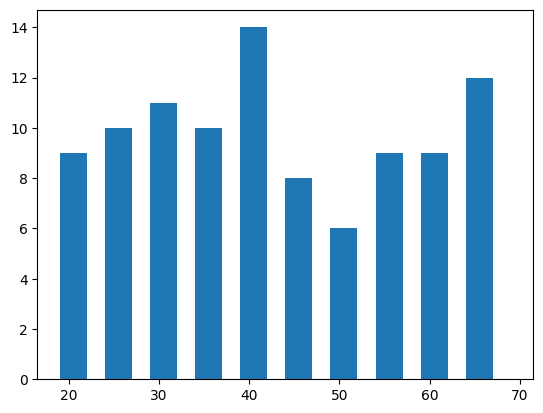

In [385]:
plt.hist(df1["Age"], width=3)
# plt.hist(df1["Salary"], width=3)
# plt.hist(df1["ExperienceYears"], width=3)
# plt.hist(df1["PurchaseAmount"], width=3)
# plt.hist(df1["Salary"], width=3)
plt.show()

No Outlier detection Found

### **Handle Missing Values**

In [386]:
from sklearn.impute import SimpleImputer

In [387]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              98 non-null     float64
 1   Gender           98 non-null     object 
 2   MaritalStatus    97 non-null     object 
 3   EducationLevel   98 non-null     object 
 4   Salary           98 non-null     float64
 5   ExperienceYears  97 non-null     float64
 6   PurchaseAmount   96 non-null     float64
 7   CustomerReview   100 non-null    object 
 8   SignupDate       96 non-null     object 
 9   IsChurn          100 non-null    int64  
dtypes: float64(4), int64(1), object(5)
memory usage: 7.9+ KB


#### **Numerical Columns** : Using Mean/ Median Values

In [388]:
import numpy as np

In [389]:
num_imputer = SimpleImputer()

In [390]:
num_cols = df1.select_dtypes(include=["float64"]).columns.to_list()
num_cols

['Age', 'Salary', 'ExperienceYears', 'PurchaseAmount']

In [391]:
df1[num_cols] = num_imputer.fit_transform(df1[num_cols])
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              100 non-null    float64
 1   Gender           98 non-null     object 
 2   MaritalStatus    97 non-null     object 
 3   EducationLevel   98 non-null     object 
 4   Salary           100 non-null    float64
 5   ExperienceYears  100 non-null    float64
 6   PurchaseAmount   100 non-null    float64
 7   CustomerReview   100 non-null    object 
 8   SignupDate       96 non-null     object 
 9   IsChurn          100 non-null    int64  
dtypes: float64(4), int64(1), object(5)
memory usage: 7.9+ KB


#### **Catogorical Columns** : Using mode

In [392]:
cat_imputer = SimpleImputer(strategy="most_frequent")

In [393]:
cat_cols = df1.select_dtypes(include=["object"]).drop(["CustomerReview"], axis=1).columns.to_list()
cat_cols

['Gender', 'MaritalStatus', 'EducationLevel', 'SignupDate']

In [394]:
df1[cat_cols] = cat_imputer.fit_transform(df1[cat_cols])
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              100 non-null    float64
 1   Gender           100 non-null    object 
 2   MaritalStatus    100 non-null    object 
 3   EducationLevel   100 non-null    object 
 4   Salary           100 non-null    float64
 5   ExperienceYears  100 non-null    float64
 6   PurchaseAmount   100 non-null    float64
 7   CustomerReview   100 non-null    object 
 8   SignupDate       100 non-null    object 
 9   IsChurn          100 non-null    int64  
dtypes: float64(4), int64(1), object(5)
memory usage: 7.9+ KB


### **Data Transformation**

#### **Encording Categorical Columns**

In [395]:
from sklearn.preprocessing import OneHotEncoder

In [396]:
cat_cols

['Gender', 'MaritalStatus', 'EducationLevel', 'SignupDate']

In [397]:
ohe = OneHotEncoder()

In [398]:
encorded_cat_cols = ohe.fit_transform(df1[cat_cols[0:-1]]) # Without SignUp date Column
encorded_col_names = ohe.get_feature_names_out()
encorded_col_names

array(['Gender_Female', 'Gender_Male', 'MaritalStatus_Divorced',
       'MaritalStatus_Married', 'MaritalStatus_Single',
       "EducationLevel_Bachelor's", 'EducationLevel_High School',
       "EducationLevel_Master's", 'EducationLevel_PhD'], dtype=object)

In [399]:
encorded_cat_df = pd.DataFrame(encorded_cat_cols.toarray(), columns=encorded_col_names) 
encorded_cat_df.sample(5)

,Gender_Female,Gender_Male,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,EducationLevel_Bachelor's,EducationLevel_High School,EducationLevel_Master's,EducationLevel_PhD
70,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
84,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
15,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
55,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
23,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


#### **Ordinal Encording Categorical Columns**

In [400]:
from sklearn.preprocessing import OrdinalEncoder

In [401]:
education_order = ['High School', 'Bachelor\'s', 'Master\'s', "PhD"]
ordinal_encorder1 = OrdinalEncoder(categories=[education_order])

In [402]:
df1["EducationLevel"] = ordinal_encorder1.fit_transform(df1[["EducationLevel"]])
df1.sample()

,Age,Gender,MaritalStatus,EducationLevel,Salary,ExperienceYears,PurchaseAmount,CustomerReview,SignupDate,IsChurn
60,25.0,Female,Divorced,3.0,116872.66,29.0,263.64,President our Mr discussion little family.,4/28/2024,0


In [403]:
marital_order = ["Single", "Married", "Divorced"]
ordinal_encorder2 = OrdinalEncoder(categories=[marital_order])

In [404]:
df1["MaritalStatus"] = ordinal_encorder2.fit_transform(df1[["MaritalStatus"]])
df1.sample()

,Age,Gender,MaritalStatus,EducationLevel,Salary,ExperienceYears,PurchaseAmount,CustomerReview,SignupDate,IsChurn
37,68.0,Male,2.0,1.0,30466.64,12.0,463.33,Community throw be size suddenly nothing. Mind...,6/2/2022,1


#### **Scalling Numerical Features**

In [405]:
from sklearn.preprocessing import MinMaxScaler

In [406]:
num_cols

['Age', 'Salary', 'ExperienceYears', 'PurchaseAmount']

In [407]:
scaler = MinMaxScaler()
df1[num_cols] = scaler.fit_transform(df1[num_cols])
df1.sample()

,Age,Gender,MaritalStatus,EducationLevel,Salary,ExperienceYears,PurchaseAmount,CustomerReview,SignupDate,IsChurn
62,0.66,Female,2.0,3.0,0.845833,0.631579,0.52602,System now chair fight later of. Other boy gro...,1/11/2022,1


#### **Text Preprocessing**

In [408]:
from sklearn.feature_extraction.text import CountVectorizer

In [409]:
vectorizer = CountVectorizer(stop_words="english", max_features=100)

In [410]:
type(df1[["CustomerReview"]])

pandas.core.frame.DataFrame

In [411]:
vectorizer_matrix = vectorizer.fit_transform(df1["CustomerReview"]).toarray()
vectorizer_columns = vectorizer.get_feature_names_out()
print(vectorizer_columns)

['able' 'action' 'address' 'admit' 'age' 'agency' 'analysis' 'assume'
 'baby' 'bank' 'behavior' 'box' 'boy' 'break' 'center' 'chair' 'check'
 'child' 'clear' 'company' 'condition' 'country' 'cut' 'day' 'deal'
 'doctor' 'door' 'draw' 'eat' 'economy' 'effect' 'end' 'exactly' 'expert'
 'explain' 'feeling' 'figure' 'fish' 'form' 'friend' 'general' 'grow'
 'guess' 'hot' 'increase' 'interview' 'later' 'lead' 'let' 'life' 'little'
 'loss' 'member' 'middle' 'old' 'page' 'paper' 'pattern' 'play' 'police'
 'political' 'price' 'production' 'professional' 'provide' 'purpose'
 'race' 'read' 'reality' 'region' 'relate' 'risk' 'road' 'rock' 'role'
 'room' 'scene' 'science' 'security' 'senior' 'series' 'service' 'speech'
 'station' 'step' 'success' 'successful' 'suddenly' 'support' 'talk'
 'team' 'technology' 'television' 'tell' 'test' 'thank' 'true' 'try' 'tv'
 'white']


In [412]:
count_vectorizer_df = pd.DataFrame(vectorizer_matrix, columns=vectorizer_columns)
count_vectorizer_df.head()

,able,action,address,admit,age,agency,analysis,assume,baby,bank,...,team,technology,television,tell,test,thank,true,try,tv,white
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### **Concatenate Encorded data and Vectorizer data**

In [413]:
df1 = pd.concat([df1, encorded_cat_df, count_vectorizer_df], axis=1)
df1.sample()

,Age,Gender,MaritalStatus,EducationLevel,Salary,ExperienceYears,PurchaseAmount,CustomerReview,SignupDate,IsChurn,...,team,technology,television,tell,test,thank,true,try,tv,white
6,0.38,Male,2.0,1.0,0.750515,1.0,0.673551,Author method from early sort speech service. ...,12/25/2023,1,...,0,0,0,0,0,0,0,0,0,0


In [414]:
df1 = df1.drop("CustomerReview", axis=1)
df1.head()

,Age,Gender,MaritalStatus,EducationLevel,Salary,ExperienceYears,PurchaseAmount,SignupDate,IsChurn,Gender_Female,...,team,technology,television,tell,test,thank,true,try,tv,white
0,0.740000,Male,1.0,3.0,0.771574,0.105263,0.956849,6/15/2023,1,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1.000000,Male,1.0,3.0,0.038832,0.289474,0.572614,8/26/2024,1,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.540000,Male,2.0,0.0,1.000000,0.552632,0.632106,2/20/2023,0,0.0,...,0,0,0,0,1,0,0,0,0,0
3,0.260000,Male,1.0,1.0,0.469755,0.657895,0.445281,11/10/2024,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0.488163,Male,2.0,0.0,0.277325,0.657895,0.287136,4/7/2022,0,0.0,...,0,0,0,0,0,0,0,0,0,0


##
---

## **Method 02** : Using PipeLines

### **Data Collection**

In [415]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer

In [416]:
df2 = pd.read_csv("../datasets/synthetic_dataset_1.csv")
df2.sample()

,CustomerID,Age,Gender,MaritalStatus,EducationLevel,Salary,ExperienceYears,PurchaseAmount,CustomerReview,SignupDate,IsChurn
24,25,38.0,Female,Divorced,High School,62278.21,24.0,410.18,Light agency movie state policy enter. Off act...,9/10/2023,1


In [417]:
# Feature Groups
num_cols = ["Age", "Salary", "ExperienceYears", "PurchaseAmount"]
onehot_cat_cols = ["Gender"]
ordinal_cat_cols = ["MaritalStatus", "EducationLevel"]
text_col = "CustomerReview"

In [418]:
# Define Ordinal Mappings
education_mapping = ["High School", "Bachelor's", "Master's", "PhD"]
marital_mapping = ["Single", "Married", "Divorced"]

### **Data Transformation**

#### **Create Pipelines**

In [419]:
# Numerical Pipeline
num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])
num_pipeline

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())])

In [420]:
# Categorical Pipeline: OneHotEncoding
onehot_cat_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(drop="first"))
])
onehot_cat_pipeline

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(drop='first'))])

In [421]:
# Categorical Pipeline: OrdinalEncoding
ordinal_cat_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(categories=[marital_mapping, education_mapping]))
])
ordinal_cat_pipeline

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('ordinal',
                 OrdinalEncoder(categories=[['Single', 'Married', 'Divorced'],
                                            ['High School', "Bachelor's",
                                             "Master's", 'PhD']]))])

In [422]:
# Text Pipeline: TF-IDF
text_pipeline = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(max_features=100))
])
text_pipeline

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=100))])

#### **Appling Column Transfer**

In [423]:
# Combine Pipelines in ColumnTransformer
# ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ("num", num_pipeline, num_cols),
    ("onehot_cat", onehot_cat_pipeline, onehot_cat_cols),
    ("ordinal_cat", ordinal_cat_pipeline, ordinal_cat_cols),
    ("text", text_pipeline, text_col)
])
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'Salary', 'ExperienceYears',
                                  'PurchaseAmount']),
                                ('onehot_cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='first'))]),
                                 ['Gender']),
                                ('ordinal_cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['Single',
                                                                              'Married',
                                                                              'Divorced'],
                                                                             ['High '
                                                                              'School',
                                                                              "Bachelor's",
                                                                              "Master's",
                                                                              'PhD']]))]),
                                 ['MaritalStatus', 'EducationLevel']),
                                ('text',
                                 Pipeline(steps=[('tfidf',
                                                  TfidfVectorizer(max_features=100))]),
                                 'CustomerReview')])

#### **Separate Features & Target Data**

In [424]:
# Prepare Data
X = df2.drop(["CustomerID", "IsChurn"], axis=1)
y = df2["IsChurn"]
X.columns

Index(['Age', 'Gender', 'MaritalStatus', 'EducationLevel', 'Salary',
       'ExperienceYears', 'PurchaseAmount', 'CustomerReview', 'SignupDate'],
      dtype='object')

#### **Apply Preprocessing**


In [425]:
# Apply Preprocessing
X_preprocessed = preprocessor.fit_transform(X).toarray()
X_preprocessed 

array([[ 0.86449139,  1.1067034 , -1.57245715, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.75700519, -1.35661885, -0.92497479, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.17794231,  1.87462142,  0.        , ...,  0.        ,
         0.        ,  0.68769274],
       ...,
       [ 1.00180121, -1.18484309,  0.55498488, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.17794231, -0.44662363, -0.73997984, ...,  0.        ,
         0.        ,  0.        ],
       [-0.7832264 ,  1.82351672,  0.83247732, ...,  0.        ,
         0.        ,  0.        ]])

In [426]:
preprocessor.get_feature_names_out()

array(['num__Age', 'num__Salary', 'num__ExperienceYears',
       'num__PurchaseAmount', 'onehot_cat__Gender_Male',
       'ordinal_cat__MaritalStatus', 'ordinal_cat__EducationLevel',
       'text__able', 'text__action', 'text__address', 'text__admit',
       'text__after', 'text__against', 'text__age', 'text__agency',
       'text__analysis', 'text__assume', 'text__baby', 'text__bank',
       'text__chair', 'text__check', 'text__child', 'text__clear',
       'text__company', 'text__condition', 'text__country', 'text__cut',
       'text__day', 'text__deal', 'text__describe', 'text__do',
       'text__doctor', 'text__during', 'text__eat', 'text__economy',
       'text__effect', 'text__eight', 'text__else', 'text__end',
       'text__exactly', 'text__expert', 'text__explain', 'text__feeling',
       'text__figure', 'text__fish', 'text__form', 'text__friend',
       'text__general', 'text__go', 'text__grow', 'text__guess',
       'text__he', 'text__his', 'text__hot', 'text__increase',
    

In [427]:
# Get Feature Names
onehot_features = preprocessor.named_transformers_["onehot_cat"].named_steps["encoder"].get_feature_names_out(onehot_cat_cols)
tfidf_features = preprocessor.named_transformers_["text"].named_steps["tfidf"].get_feature_names_out()
processed_columns = num_cols + list(onehot_features) + ordinal_cat_cols + list(tfidf_features)

In [428]:
onehot_features

array(['Gender_Male'], dtype=object)

In [429]:
tfidf_features

array(['able', 'action', 'address', 'admit', 'after', 'against', 'age',
       'agency', 'analysis', 'assume', 'baby', 'bank', 'chair', 'check',
       'child', 'clear', 'company', 'condition', 'country', 'cut', 'day',
       'deal', 'describe', 'do', 'doctor', 'during', 'eat', 'economy',
       'effect', 'eight', 'else', 'end', 'exactly', 'expert', 'explain',
       'feeling', 'figure', 'fish', 'form', 'friend', 'general', 'go',
       'grow', 'guess', 'he', 'his', 'hot', 'increase', 'interview',
       'later', 'lead', 'let', 'life', 'little', 'loss', 'member',
       'middle', 'of', 'old', 'onto', 'our', 'page', 'paper', 'pattern',
       'play', 'police', 'political', 'price', 'production',
       'professional', 'provide', 'purpose', 'race', 'read', 'region',
       'relate', 'rock', 'role', 'scene', 'service', 'speech', 'station',
       'step', 'success', 'successful', 'suddenly', 'support', 'system',
       'take', 'team', 'tell', 'ten', 'thank', 'this', 'those', 'true',
      

In [430]:
processed_columns

['Age',
 'Salary',
 'ExperienceYears',
 'PurchaseAmount',
 'Gender_Male',
 'MaritalStatus',
 'EducationLevel',
 'able',
 'action',
 'address',
 'admit',
 'after',
 'against',
 'age',
 'agency',
 'analysis',
 'assume',
 'baby',
 'bank',
 'chair',
 'check',
 'child',
 'clear',
 'company',
 'condition',
 'country',
 'cut',
 'day',
 'deal',
 'describe',
 'do',
 'doctor',
 'during',
 'eat',
 'economy',
 'effect',
 'eight',
 'else',
 'end',
 'exactly',
 'expert',
 'explain',
 'feeling',
 'figure',
 'fish',
 'form',
 'friend',
 'general',
 'go',
 'grow',
 'guess',
 'he',
 'his',
 'hot',
 'increase',
 'interview',
 'later',
 'lead',
 'let',
 'life',
 'little',
 'loss',
 'member',
 'middle',
 'of',
 'old',
 'onto',
 'our',
 'page',
 'paper',
 'pattern',
 'play',
 'police',
 'political',
 'price',
 'production',
 'professional',
 'provide',
 'purpose',
 'race',
 'read',
 'region',
 'relate',
 'rock',
 'role',
 'scene',
 'service',
 'speech',
 'station',
 'step',
 'success',
 'successful',
 'sudd

#### **Convert to DataFrame** 

In [431]:
# Convert to DataFrame
processed_df = pd.DataFrame(X_preprocessed, columns=processed_columns)
processed_df.sample(5)

,Age,Salary,ExperienceYears,PurchaseAmount,Gender_Male,MaritalStatus,EducationLevel,able,action,address,...,tell,ten,thank,this,those,true,try,tv,under,whether
76,1.207766,-1.229981,0.092497,1.361741,1.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,-0.371297,1.035907,1.572457,0.441699,1.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.864491,1.106703,-1.572457,1.362390,1.0,1.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55,-0.439952,-0.474309,0.369990,1.090880,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62,0.589872,1.356345,0.277492,-0.037761,0.0,2.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [432]:
# Add Target Column
processed_df["IsChurn"] = y.values

In [433]:
# Final Preprocessed Dataset
processed_df.head()

,Age,Salary,ExperienceYears,PurchaseAmount,Gender_Male,MaritalStatus,EducationLevel,able,action,address,...,ten,thank,this,those,true,try,tv,under,whether,IsChurn
0,0.864491,1.106703,-1.572457,1.362390,1.0,1.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1
1,1.757005,-1.356619,-0.924975,0.113665,1.0,1.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1
2,0.177942,1.874621,0.000000,0.307008,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.687693,0
3,-0.783226,0.092053,0.369990,-0.300156,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.419157,0.0,0.0,0.0,0.0,0.0,0.000000,0
4,0.000000,-0.554858,0.369990,-0.814109,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.723378,0


##
---

## Full Code Using Pipeline

In [434]:
# Full Code Using Pipeline

import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer

# Sample DataFrame
data = {
    "CustomerID": [1, 2, 3, 4, 5],
    "Age": [25, np.nan, 35, 45, 50],
    "Salary": [50000, 60000, np.nan, 80000, 100000],
    "ExperienceYears": [2, 5, np.nan, 10, 15],
    "PurchaseAmount": [200, 400, 600, np.nan, 1000],
    "Gender": ["Male", "Female", "Female", "Male", "Female"],
    "MaritalStatus": ["Single", "Married", "Divorced", "Single", "Married"],
    "EducationLevel": ["High School", "Bachelor's", "Master's", "PhD", "Master's"],
    "CustomerReview": [
        "Excellent service",
        "Good but could improve",
        "Average experience",
        "Very poor service",
        "Loved it!"
    ],
    "IsChurn": [0, 1, 0, 1, 0],
}
df = pd.DataFrame(data)

# Feature Groups
num_cols = ["Age", "Salary", "ExperienceYears", "PurchaseAmount"]
onehot_cat_cols = ["Gender"]
ordinal_cat_cols = ["MaritalStatus", "EducationLevel"]
text_col = "CustomerReview"

# Define Ordinal Mappings
education_mapping = ["High School", "Bachelor's", "Master's", "PhD"]
marital_mapping = ["Single", "Married", "Divorced"]

# Pipelines for each group
# Numerical Pipeline
num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

# Categorical Pipeline: OneHotEncoding
onehot_cat_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(drop="first"))
])

# Categorical Pipeline: OrdinalEncoding
ordinal_cat_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(categories=[marital_mapping, education_mapping]))
])

# Text Pipeline: TF-IDF
text_pipeline = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(max_features=100))
])

# ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ("num", num_pipeline, num_cols),
    ("onehot_cat", onehot_cat_pipeline, onehot_cat_cols),
    ("ordinal_cat", ordinal_cat_pipeline, ordinal_cat_cols),
    ("text", text_pipeline, text_col)
])

# Prepare Data
X = df.drop(["CustomerID", "IsChurn"], axis=1)
y = df["IsChurn"]

# Apply Preprocessing
X_preprocessed = preprocessor.fit_transform(X)

# Get Feature Names
onehot_features = preprocessor.named_transformers_["onehot_cat"].named_steps["encoder"].get_feature_names_out(onehot_cat_cols)
tfidf_features = preprocessor.named_transformers_["text"].named_steps["tfidf"].get_feature_names_out()
processed_columns = num_cols + list(onehot_features) + ordinal_cat_cols + list(tfidf_features)

# Convert to DataFrame
processed_df = pd.DataFrame(X_preprocessed, columns=processed_columns)

# Add Target Column
processed_df["IsChurn"] = y.values

# Final Preprocessed Dataset
processed_df.sample(5)

,Age,Salary,ExperienceYears,PurchaseAmount,Gender_Male,MaritalStatus,EducationLevel,average,but,could,excellent,experience,good,improve,it,loved,poor,service,very,IsChurn
0,-1.601112,-1.310001,-1.355262,-1.322876,1.0,0.0,0.0,0.000000,0.0,0.0,0.778283,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.627914,0.000000,0
1,0.000000,-0.727778,-0.677631,-0.566947,0.0,1.0,1.0,0.000000,0.5,0.5,0.000000,0.000000,0.5,0.5,0.000000,0.000000,0.000000,0.000000,0.000000,1
3,0.727778,0.436667,0.451754,0.000000,1.0,0.0,3.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.614189,0.495524,0.614189,1
4,1.310001,1.601112,1.581139,1.700840,0.0,1.0,2.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.707107,0.707107,0.000000,0.000000,0.000000,0
2,-0.436667,0.000000,0.000000,0.188982,0.0,2.0,2.0,0.707107,0.0,0.0,0.000000,0.707107,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0


### Create Model with Pipeline

In [435]:
from sklearn.model_selection import train_test_split 

In [436]:
X = df.drop('IsChurn',axis=1) 
y = df["IsChurn"]

In [437]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [438]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline

In [439]:
model_pipeline = make_pipeline(preprocessor, DecisionTreeClassifier())

In [440]:
model_pipeline.fit(X_train, y_train) 

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Salary',
                                                   'ExperienceYears',
                                                   'PurchaseAmount']),
                                                 ('onehot_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Gender']),
                                                 ('ordinal_c...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Single',
                                                                                               'Married',
                                                                                               'Divorced'],
                                                                                              ['High '
                                                                                               'School',
                                                                                               "Bachelor's",
                                                                                               "Master's",
                                                                                               'PhD']]))]),
                                                  ['MaritalStatus',
                                                   'EducationLevel']),
                                                 ('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=100))]),
                                                  'CustomerReview')])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [441]:
pred = model_pipeline.predict(X_test)
pred

array([0, 0])

In [442]:
y_test

2    0
1    1
Name: IsChurn, dtype: int64

### Model Save

In [443]:
import joblib

In [444]:
joblib.dump(model_pipeline, "model_with_pipline.sav")

['model_with_pipline.sav']

### Model Load

In [445]:
model = joblib.load("model_with_pipline.sav")
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Salary',
                                                   'ExperienceYears',
                                                   'PurchaseAmount']),
                                                 ('onehot_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Gender']),
                                                 ('ordinal_c...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Single',
                                                                                               'Married',
                                                                                               'Divorced'],
                                                                                              ['High '
                                                                                               'School',
                                                                                               "Bachelor's",
                                                                                               "Master's",
                                                                                               'PhD']]))]),
                                                  ['MaritalStatus',
                                                   'EducationLevel']),
                                                 ('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=100))]),
                                                  'CustomerReview')])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [446]:
pred = model.predict(X_test)
pred

array([0, 0])

#
---